In [ ]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### Step 0: Load Required Libraries

This initial step imports the essential Python libraries needed to run CEFR classification experiments using Large Language Models (LLMs):

- `openai`: For querying GPT models.
- `pandas` and `numpy`: For data manipulation and numerical operations.
- `tiktoken`: For counting tokens in prompts/responses to estimate costs.

Please ensure that these packages are installed in your environment before running the next steps.


In [17]:
# Install necessary libraries if not already installed
# !pip install openai tiktoken pandas numpy

from openai import OpenAI
import pandas as pd
import numpy as np
import tiktoken
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


### Step 1: Load Dataset

In this step, we load the dataset containing CEFR-labeled sentences used for model evaluation.

- `train_data.csv`: Contains the training portion of the dataset.
- `test_data.csv`: Contains the test portion for evaluating zero-shot and fine-tuned models.
- Each dataset is assumed to have at least the following columns:
  - `sentence`: The text to classify.
  - `difficulty_label`: The true CEFR level (e.g., A1, A2, B1, ..., C2).

This split will allow us to run consistent evaluations across model variants.


In [18]:
train_data = pd.read_csv("./Data/train_data.csv")
test_data = pd.read_csv("./Data/test_data.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
# Display the first few rows of the training data
print("Training data:")
display(train_data.head())
print("Test data:")
display(test_data.head())

Train size: 2817
Test size: 705
Training data:


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Zur Vorbereitung sollte man mit einem Arm eine...,3,306,19,27.0,139.0,B2,69.11,B2
1,Es ist ein sehr schöner Abend.,0,531,6,NaN,NaN,A1,99.23,A1
2,Heute führt die Route durch das Gaistal.,1,476,7,10.0,115.0,A2,115.13,A2
3,Als besser verträglich mit dem Leitbild der na...,5,unknown,14,NaN,NaN,C2,31.89,C2
4,Hierzulande liegen sie im Schnitt bei 15. 000 ...,2,483,9,15.0,121.0,B1,87.72,B1


Test data:


,sentence,difficulty,text_id,sentence_length,sentence_tokens,total_tokens_per_call,difficulty_reviewed,readability,difficulty_label
0,Es steht an gefährlichen Kreuzungen oder Einmü...,3,638,13,NaN,NaN,B2,49.82,B2
1,1988 entstand in den USA die „International Da...,4,283,24,43.0,150.0,C1,38.66,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",5,unknown,24,NaN,NaN,C2,67.76,C2
3,Architekten können heute keine Bauwerke mehr s...,5,unknown,22,NaN,NaN,C2,57.61,C2
4,60 Prozent verwenden das Taschengeld auch für ...,2,654,10,NaN,NaN,B1,86.71,B1


### Step 2: Define Prompt-Based Classification Function

This section defines a function to query a Large Language Model (LLM) via the OpenAI API to classify the CEFR difficulty level of a sentence.

- The model used is `gpt-4o` by default, but it can be changed to other available models (e.g., `gpt-4`, `gpt-3.5-turbo`).
- The prompt is structured to elicit one of six CEFR levels (A1 to C2), with strict instruction to return only the label.
- The function returns the predicted label as a string or `None` in case of error.

> ⚠️ **Note:** You must ensure your OpenAI API key is correctly set and handled securely.


In [ ]:

# Set your OpenAI API key
client = OpenAI(api_key="")

# CEFR classification via prompt
def query_openai_gpt(sentence, model="gpt-4o"):
    prompt = f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{sentence}"
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a CEFR language proficiency classifier."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            max_tokens=2,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("API call failed:", e)
        return None



Here you can ensure that you set up correctly your api key.

In [23]:
print(query_openai_gpt("Architekten können heute keine Bauwerke mehr schaffen wie das Bremer Rathaus, das über Jahrhunderte hinweg ein Symbol der Bürgerschaft war und ist.", "gpt-4o"))  # grammatically correct


C1


### Step 3: Token Counting and Cost Estimation

To manage and estimate the cost of using OpenAI's API, it's essential to understand how many tokens are consumed per request. This section introduces functions to count tokens in prompts and responses and estimate the cost based on the model's pricing.

**Key Points:**

- **Token Counting:** We use the `tiktoken` library to count the number of tokens in the prompt and response. Different models use different encodings; for instance, `gpt-4o` uses the `o200k_base` encoding.

- **Cost Estimation:** OpenAI charges per 1,000 tokens. As of now, the pricing for `gpt-4o` is:
  - Input: $0.005 per 1,000 tokens
  - Output: $0.0015 per 1,000 tokens

*Note: Always refer to the [OpenAI Pricing](https://openai.com/pricing) page for the most up-to-date information.*


In [9]:

# Function to count tokens in a given text using the appropriate encoding for the model
def count_tokens(text, model="gpt-4.5-preview"):
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        # Fallback encoding
        encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(text))

# Function to estimate the cost of a single API call based on token usage
def estimate_cost(input_tokens, output_tokens, model="gpt-4o"):
    # Pricing per 1,000 tokens (USD)
    pricing = {
        "gpt-3.5-turbo": {"input": 0.50, "output": 1.50},
        "gpt-4":         {"input": 30.00,   "output": 60.00},
        "gpt-4o":        {"input": 2.50,  "output": 10.00},
        "gpt-4o-mini":   {"input": 0.15,   "output": 0.60},  

        # Newly observed models (pricing per 1M tokens)
        "gpt-4.1":        {"input": 2.00,   "output": 8.00},   # cached input = $0.50
        "gpt-4.1-mini":   {"input": 0.40,   "output": 1.60},   # cached input = $0.10
        "gpt-4.5-preview":{"input": 75.00,   "output": 150.00},   # cached input = $37.50
    }

    if model not in pricing:
        raise ValueError(f"Pricing for model '{model}' is not defined.")

    input_price = pricing[model]["input"]
    output_price = pricing[model]["output"]

    input_cost = (input_tokens / 1_000_000) * input_price
    output_cost = (output_tokens / 1_000_000) * output_price

    total_cost = input_cost + output_cost

    return round(total_cost, 6)



Processing gpt-3.5-turbo:   0%|          | 0/705 [00:00<?, ?it/s]/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Processing gpt-4.5-preview: 100%|██████████| 705/705 [00:00<00:00, 6382.81it/s]
/var/folders/wb/btfl8bv91b5c253kbpftk1940000gn/T/ipykernel_87066/3307426010.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


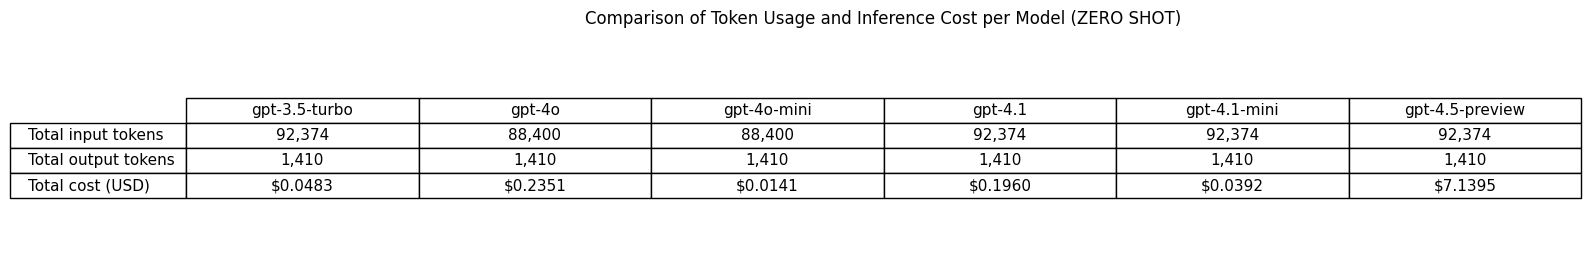

In [10]:
# ----------------------------
# Configuration
# ----------------------------
models = ["gpt-3.5-turbo", "gpt-4o", "gpt-4o-mini", "gpt-4.1", "gpt-4.1-mini", "gpt-4.5-preview"]
assumed_output_tokens_per_sentence = 2
total_output_tokens = assumed_output_tokens_per_sentence * len(test_data)

# Prepare a structure to hold results
results = {
    "Metric": ["Total input tokens", "Total output tokens", "Total cost (USD)"]
}

# ----------------------------
# Compute for each model
# ----------------------------
for model in models:
    total_input_tokens = 0

    for sentence in tqdm(test_data["sentence"], desc=f"Processing {model}"):
        prompt = f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{sentence}"
"""
        total_input_tokens += count_tokens(prompt, model=model)

    total_cost = estimate_cost(total_input_tokens, total_output_tokens, model=model)

    results[model] = [
        f"{total_input_tokens:,}",
        f"{total_output_tokens:,}",
        f"${total_cost:,.4f}"
    ]

# ----------------------------
# Build the table
# ----------------------------
import pandas as pd

df_costs = pd.DataFrame(results).set_index("Metric")

# Plotting the table using matplotlib
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis("off")

table = ax.table(
    cellText=df_costs.values,
    rowLabels=df_costs.index,
    colLabels=df_costs.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 1.5)

plt.title("Comparison of Token Usage and Inference Cost per Model (ZERO SHOT)", fontsize=12, pad=20)
plt.tight_layout()
plt.show()


### Step 4: Run Model Prediction and Store Results

In this step, we use the previously defined `query_openai_gpt()` function to run CEFR classification on all test sentences using a selected model.

The results are stored in a new column of the test dataset. This enables downstream evaluation and comparison between models.

> ⚠️ Long-running operations should include optional checkpointing to avoid data loss in case of an interruption.


In [11]:
# Choose model to run (change as needed)
selected_model = "gpt-4.5-preview"  # or "gpt-4o", "gpt-4", "gpt-4.1", "gpt-4.1-mini", "gpt-4.5-preview"

# Column to store predictions
test_data[f"prediction_{selected_model}"] = None

# Limiter to test the model
#max_call = 10
#if max_call > 0:
#    test_data = test_data.iloc[:max_call]

# Run model prediction
for i, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"Running predictions with {selected_model}"):
    sentence = row["sentence"]
    prediction = query_openai_gpt(sentence, model=selected_model)
    test_data.at[i, f"prediction_{selected_model}"] = prediction

    # Optional sleep to throttle requests (especially for rate-limited APIs)
    time.sleep(0.25)

# Save predictions to file for backup
test_data.to_csv(f"./Data/Predictions/predictions_{selected_model}.csv", index=False)
print(f"Predictions saved to predictions_{selected_model}.csv")



Running predictions with gpt-4.5-preview: 100%|██████████| 705/705 [13:02<00:00,  1.11s/it]

Predictions saved to predictions_gpt-4.5-preview.csv


### 5. Evaluation

#### Step 5.1: Load and Aggregate Model Predictions

This step loads all prediction files stored in `./Data/Predictions/` and consolidates them into a single evaluation dataset.

Each CSV is assumed to include the original `sentence`, `label`, and a model-specific prediction column named `prediction_<model>`.

This enables easy evaluation and comparison across models.


In [1]:
import os
import pandas as pd

# Folder where predictions are stored
prediction_folder = "./Data/Predictions"

# Initialize with the first CSV to get base structure
combined_df = None

# Load all CSVs and merge on sentence/label
for file in os.listdir(prediction_folder):
    if file.endswith(".csv") and file.startswith("predictions_"):
        model_name = file.replace("predictions_", "").replace(".csv", "")
        path = os.path.join(prediction_folder, file)
        
        df = pd.read_csv(path)
        df = df[["sentence", "difficulty_label", f"prediction_{model_name}"]]

        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=["sentence", "difficulty_label"], how="inner")

# Display summary
print(f"Loaded predictions from {len(combined_df.columns) - 2} models.")
combined_df.head()


Loaded predictions from 7 models.


,sentence,difficulty_label,prediction_gpt-4o_few_shots,prediction_gpt-3.5-turbo,prediction_gpt-4.1,prediction_gpt-4.1_few_shots,prediction_gpt-3.5-turbo_few_shots,prediction_gpt-4.5-preview,prediction_gpt-4o
0,Es steht an gefährlichen Kreuzungen oder Einmü...,B2,B2,B2,B1,B1,B2,B1,B2
1,1988 entstand in den USA die „International Da...,C1,C1,C1,B2,B2,C1,B2,C1
2,"Die Denkweise, Häuser als Maschinen, in denen ...",C2,C2,C1,C1,C1,C1,C1,C1
3,Architekten können heute keine Bauwerke mehr s...,C2,C2,C1,C1,C1,C1,C1,C1
4,60 Prozent verwenden das Taschengeld auch für ...,B1,B1,B1,A2,A2,B1,B1,A2


#### Step 5.2: Compute Accuracy & Macro‑F1 for Each Model

We evaluate each model’s predictions against the ground‑truth CEFR labels using:

- **Accuracy** – simple proportion of correct predictions.  
- **Macro‑averaged F1** – F1 averaged over the six CEFR classes (A1…C2), giving equal weight to each level.


In [2]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]

# --- containers ---
summary_rows = []                  # overall accuracy + macro‑F1
per_class_frames = []              # full per‑class reports

for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        y_true = combined_df["difficulty_label"]  # or "label" if that is your ground truth column
        y_pred = combined_df[col]

        # Drop rows with missing predictions, if any
        mask   = y_pred.notna()
        y_true = y_true[mask]
        y_pred = y_pred[mask]

        # Full classification report as dict
        report_dict = classification_report(
            y_true,
            y_pred,
            labels=label_order,
            target_names=label_order,
            output_dict=True,
            zero_division=0
        )

        # --- overall summary row ---
        summary_rows.append({
            "Model": model,
            "Accuracy": round(accuracy_score(y_true, y_pred), 4),
            "Macro‑F1": round(report_dict["macro avg"]["f1-score"], 4)
        })

        # --- per‑class DataFrame ---
        # --- per‑class DataFrame ---
        class_df = (
            pd.DataFrame(report_dict).T                      # transpose first
            .drop(index=["macro avg", "weighted avg"])
            .assign(Model=model)
            .set_index("Model", append=True)
        )
        per_class_frames.append(class_df)


# Summary table (overall)
df_metrics = (
    pd.DataFrame(summary_rows)
    .sort_values("Macro‑F1", ascending=False)
    .reset_index(drop=True)
)
display(df_metrics)

# Full per‑class metrics stacked in MultiIndex (Model, Class)
df_per_class = pd.concat(per_class_frames).rename_axis(index=["Class", "Model"])
display(df_per_class)


,Model,Accuracy,Macro‑F1
0,gpt-4o_few_shots,0.5674,0.5649
1,gpt-4o,0.5376,0.5157
2,gpt-4.1_few_shots,0.5064,0.5010
3,gpt-4.1,0.4638,0.4309
4,gpt-4.5-preview,0.3929,0.3542
5,gpt-3.5-turbo_few_shots,0.3376,0.2892
6,gpt-3.5-turbo,0.2908,0.2112


,,precision,recall,f1-score,support
Class,Model,,,,
A1,gpt-4o_few_shots,0.857143,0.666667,0.750000,117.000000
A2,gpt-4o_few_shots,0.532258,0.282051,0.368715,117.000000
B1,gpt-4o_few_shots,0.474453,0.550847,0.509804,118.000000
B2,gpt-4o_few_shots,0.478723,0.762712,0.588235,118.000000
C1,gpt-4o_few_shots,0.489051,0.567797,0.525490,118.000000
C2,gpt-4o_few_shots,0.744444,0.572650,0.647343,117.000000
accuracy,gpt-4o_few_shots,0.567376,0.567376,0.567376,0.567376
A1,gpt-3.5-turbo,1.000000,0.153846,0.266667,117.000000
A2,gpt-3.5-turbo,0.100000,0.017094,0.029197,117.000000


#### Step 5.3: Confusion Matrix per Model

A confusion matrix shows where the model confuses adjacent CEFR levels.  
Run the next cell and specify the model you want to visualise.


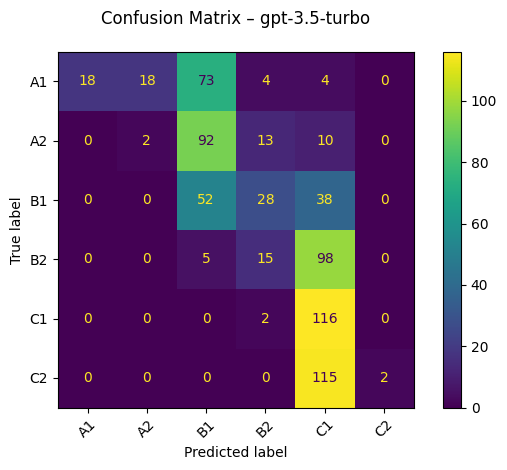

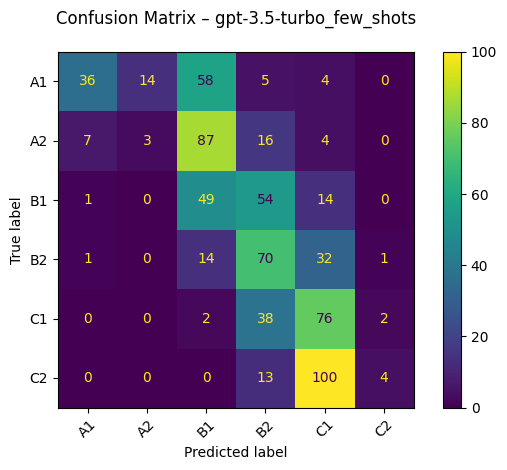

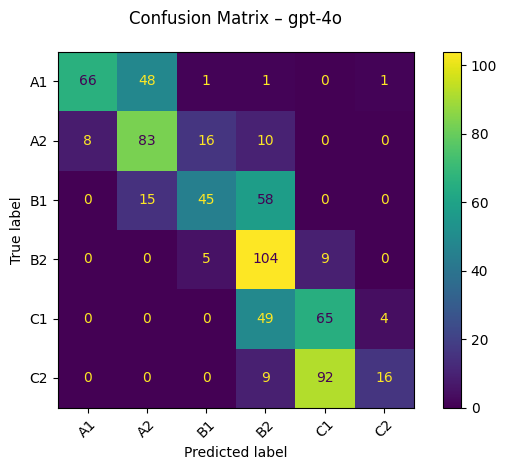

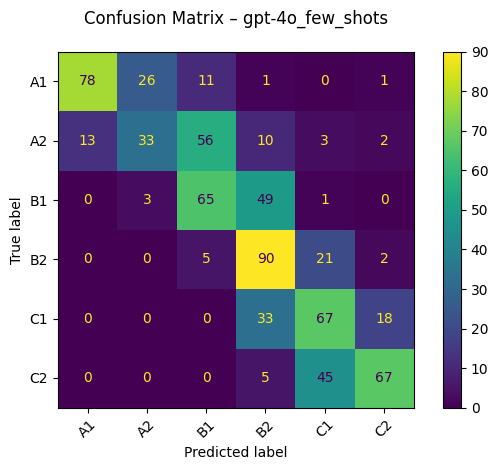

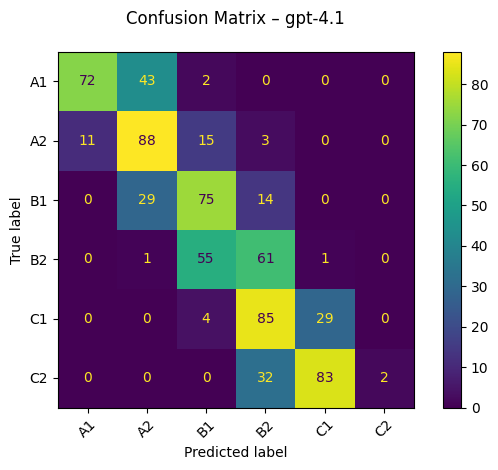

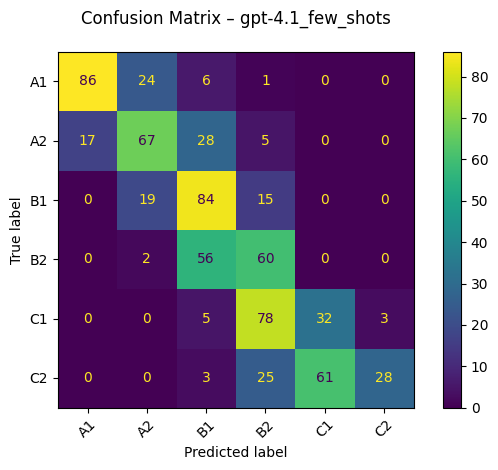

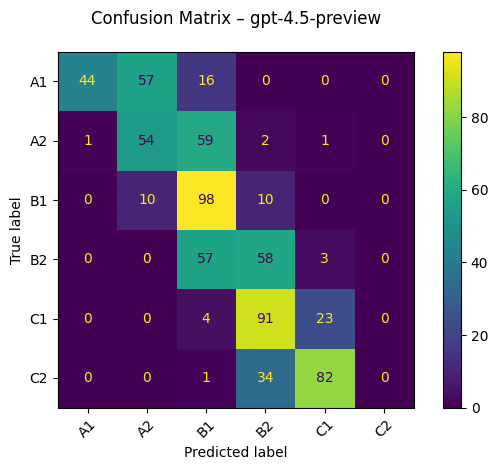

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fixed CEFR label order
label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]
label_to_idx = {lbl: i for i, lbl in enumerate(label_order)}

def plot_confusion(model_name, drop_na=True):
    """
    Plot confusion matrix for the specified model using sklearn's ConfusionMatrixDisplay.
    
    Parameters
    ----------
    model_name : str
        The model suffix used in column names, e.g. "gpt-4o".
    drop_na : bool
        If True, rows where the prediction is missing / None are dropped.
    """
    pred_col = f"prediction_{model_name}"
    if pred_col not in combined_df.columns:
        raise ValueError(f"No prediction column found for '{model_name}'")

    y_true = combined_df["difficulty_label"]
    y_pred = combined_df[pred_col]

    if drop_na:
        mask = y_pred.notna()
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    # Map CEFR labels → integer indices (0–5) for confusion_matrix
    y_true_idx = y_true.map(label_to_idx)
    y_pred_idx = y_pred.map(label_to_idx)

    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix – {model_name}", pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example:
# plot_confusion("gpt-4o")

# Example usage:
plot_confusion("gpt-3.5-turbo")
plot_confusion("gpt-3.5-turbo_few_shots")
plot_confusion("gpt-4o")
plot_confusion("gpt-4o_few_shots")
plot_confusion("gpt-4.1")
plot_confusion("gpt-4.1_few_shots")
plot_confusion("gpt-4.5-preview")
# Save the combined DataFrame with predictions

## Step 5.4 – Pairwise‑Mismatch (PM)  (Henry et al., 2024)

The CEFR labels form an **ordered scale** (A1 < A2 < B1 < B2 < C1 < C2).  
Rather than counting only exact hits, Henry et al. evaluate whether the **relative
difficulty ordering** of sentences is preserved.

<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">


In [4]:
from itertools import combinations
import numpy as np
import pandas as pd

# Fixed CEFR ranking
label_order = ["A1","A2","B1","B2","C1","C2"]
rank = {lbl:i for i,lbl in enumerate(label_order)}

def pairwise_mismatch_pm(y_true, y_pred, scale="paper"):
    """
    Pairwise‑Mismatch metric (Jamet et al., 2024).

    Parameters
    ----------
    y_true, y_pred : iterable of CEFR labels
    scale : "paper"  -> divide by N   (matches published numbers)
            "frac"   -> divide by N*(N-1)/2  (0‑1 range, scale‑free)

    Returns
    -------
    pm : float
    """
    # rank mapping
    rank = {lbl:i for i,lbl in enumerate(["A1","A2","B1","B2","C1","C2"])}

    t = np.array([rank[l] for l in y_true])
    p = np.array([rank.get(l, np.nan) for l in y_pred])

    mask = ~np.isnan(p)
    t, p = t[mask], p[mask]

    n = len(t)
    if n < 2:
        return np.nan

    v = p - t
    idx_i, idx_j = np.triu_indices(n, k=1)
    mismatches = (v[idx_i] * v[idx_j] < 0).sum()

    if scale == "paper":
        return mismatches / n              # divide by |V|
    elif scale == "frac":
        return mismatches / (n * (n-1) / 2)
    else:
        raise ValueError("scale must be 'paper' or 'frac'")


# ------------------------------------------
# Compute PM for every prediction column
# ------------------------------------------
pm_rows = []
for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        pm_val = pairwise_mismatch_pm(
            combined_df["difficulty_label"],   # ground truth column
            combined_df[col]
        )
        pm_rows.append({"Model": model, "Pairwise Mismatch": round(pm_val, 4)})

df_pm = (
    pd.DataFrame(pm_rows)
      .sort_values("Pairwise Mismatch")
      .reset_index(drop=True)
)

#print("Pairwise‑Mismatch (lower = better ordering):")
#display(df_pm)

merged_df = pd.merge(df_metrics, df_pm, on="Model")
display(merged_df)


,Model,Accuracy,Macro‑F1,Pairwise Mismatch
0,gpt-4o_few_shots,0.5674,0.5649,29.6511
1,gpt-4o,0.5376,0.5157,37.3674
2,gpt-4.1_few_shots,0.5064,0.5010,30.9390
3,gpt-4.1,0.4638,0.4309,33.1915
4,gpt-4.5-preview,0.3929,0.3542,58.7801
5,gpt-3.5-turbo_few_shots,0.3376,0.2892,72.6468
6,gpt-3.5-turbo,0.2908,0.2112,65.4128
